# Resume Scorer
8/02/2026
By Yanni Karlaftis (Github: Cactus878)

#### Libraries

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import OrdinalEncoder
import pandas as pd
import pdfplumber
import numpy as np
import joblib
import math
import re
import torch

#### Resume and Job Listing to Compare

In [5]:
resume = "Resume.pdf"

In [6]:
job_listing = """
Full job description
Are you a Data professional who has recently transitioned into Data Modelling??
Your new company
A leading Victorian State Government entity dedicated to protecting the people, places, and projects that enable the community to thrive is seeking a Junior Data Modeller for an initial 6‑month contract.This organisation plays a critical role in risk management and public-sector resilience and is continuing to strengthen its data capability to support strategic, analytic, and operational outcomes.

Your new role
As the Junior Data Modeller, you will support data and digital initiatives by assisting in mapping how front‑end systems relate to underlying data structures. Your contributions will enhance data quality, improve reporting accuracy, and support enterprise data modelling efforts. Key responsibilities include:

Analyse front‑end systems and workflows to understand how fields map to backend databases.
Contribute to logical and conceptual data models describing entities, relationships, and key business rules.
Support alignment of application‑level data structures with enterprise data models and reporting requirements.
Develop and maintain documentation such as data dictionaries, mapping documents, metadata records, and simple ER‑style diagrams.
Capture and update data lineage, ownership information, and metadata in agreed repositories.
Assist with data profiling activities to validate mappings and ensure data quality.
Support testing of integrations and reporting outputs to ensure fields and relationships populate correctly.
Identify basic data issues or inconsistencies and escalate them for remediation.
Contribute to compliance, governance, and risk processes by following controls and reporting risks where needed.
Maintain version control of documentation and promote consistency across artefacts.

What you'll need to succeed
To thrive in this role, you will bring technical curiosity, strong attention to detail, and a passion for understanding how systems and data fit together. Essential skills & experience:
Exposure to relational databases and SQL through study, projects, internships, or early work experience.
Bachelor degree in Data Science.
Basic understanding of how front‑end applications interact with back‑end databases or APIs.
Strong analytical and problem‑solving skills, with the ability to break down ambiguous problems.
Clear written communication skills and a detail‑oriented approach to documentation.
Demonstrated interest in systems, data structures, and end‑to‑end data flows.
Data analysis, Data engineering, Data modelling experience
Exposure in business intelligence or reporting & software development
Familiarity with data modelling concepts (entities, relationships, normalisation, dimensional models)
Reporting/visualisation tools (e.g., Power BI)
At least 2 years of experience

What you'll get in return
A valuable opportunity to gain hands‑on experience in an enterprise‑level data environment within the public sector.
Exposure to senior data professionals and a supportive, collaborative team culture.
The chance to develop your skills in data modelling, documentation, analytics, and systems mapping.
A meaningful role contributing to public safety, resilience, and community outcomes.
Competitive daily rate and hybrid working flexibility.

What you need to do now
If you're interested in this role, click 'apply now' to forward an up-to-date copy of your CV to Prachi.Kalyanarora@Hays.com.au, or call us now.
If this job isn't quite right for you, but you are looking for a new position, please contact us for a confidential discussion on your career.
"""

#### Vectorize, Segmentate, and Chunk Resume

In [8]:
import spacy
##---Vectorize Model---##
nlp = spacy.load("en_core_web_lg")

W0211 14:15:55.822000 28804 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [9]:
##---Get Vector For Word---##
def word_to_vector(word: str) -> np.ndarray:
    token = nlp(word)
    if token.has_vector:
        return token.vector
    else:
        # fallback for unknown words
        return np.zeros(300)

In [10]:
##---Return Textual Information And Vectorize Words For Title Classification---##
def vectorize_resume(resume_dir: str, encoder: OrdinalEncoder()) -> (pd.DataFrame, list):
    resume_data = []
    with pdfplumber.open(f'{resume_dir}') as pdf:
        # Loop through each page
        for page in pdf.pages:
            # Store words in page
            words = page.extract_words(extra_attrs=["fontname", "size"])
            for w in words:
                # Store specific attributes from every word and char in the resume page
                resume_data.append({"word": w["text"],
                            "width": w["width"],
                            "height": w["height"],
                            "left_distance": w["x0"], 
                            "bottom_distance": w["bottom"], 
                            "right_distance": w["x1"], 
                            "top_distance": w["top"],
                            "fontname": w["fontname"],
                            "fontsize": w["size"]})
        # Store pages
        pages = pdf.pages

    # Transform dict to pandas dataframe
    resume_data = pd.DataFrame(resume_data)
    # Rename col
    resume_data['original_word'] = resume_data['word']
    # Add vector to single col for each word
    resume_data['word'] = resume_data['word'].apply(lambda x: word_to_vector(x))
    # Create matrix
    vector_matrix = np.vstack(resume_data['word'].values)
    # Turn matrix into a df
    vector_df = pd.DataFrame(vector_matrix, index=resume_data.index)
    # Rename col names
    vector_df.columns = [f"vec_{i}" for i in range(vector_df.shape[1])]
    # Remove word col
    meta_df = resume_data.drop(columns=['word'])
    # Concatenate data frames
    resume_data_vec = pd.concat([vector_df, meta_df], axis=1)

    # Encode fontnames into their respective numbers for classification
    resume_data_vec['fontname'] = encoder.transform(resume_data_vec['fontname'])
    return resume_data_vec, pages

In [11]:
def get_cluster_centers(df: pd.DataFrame, predicted: np.ndarray, original_words: pd.Series, show_cluster_centers: bool) -> dict:
    cluster_centers = {"EDUCATION": [], "EXPERIENCE": [], "SKILLS":[], "PERSONAL":[]}
    
    for i, p in enumerate(predicted):
        if pd.notna(p):
            if show_cluster_centers == True:
                print(f'Cluster: {original_words[i]}')
            cluster_centers[p].append(((df.iloc[i]['left_distance'] + df.iloc[i]['right_distance']) / 2, 
                                       (df.iloc[i]['bottom_distance'] + df.iloc[i]['top_distance']) / 2))
            
    return cluster_centers

In [12]:
def calculate_word_x_and_y_position(df: pd.DataFrame, left: pd.Series, right:pd.Series, up: pd.Series, down: pd.Series) -> pd.DataFrame:
    calculate_center_position = lambda a, b: (a + b) / 2
    
    df["X"] = calculate_center_position(left, right) 
    df["Y"] =  calculate_center_position(down, up) 
    
    return df

In [13]:
##---Combine close clusters to eachother of the same category---##
def combine_close_cluster_titles(clusters: dict, threshold: int=250) -> dict:
    new_cluster_centers = {"EDUCATION": [], "EXPERIENCE": [], "SKILLS":[], "PERSONAL":[]}
    
    clusters_to_skip = []
    for index, cluster_arr in clusters.items():
        # Check if more titles exist for this category
        if len(cluster_arr) > 1:
            for i in cluster_arr:
                closest_index_to_i_val = float('inf')
                closest_index_to_i_pos = None
                # Skip if i has already combined previously
                if i in clusters_to_skip:
                    continue
                else:
                    for j in cluster_arr:
                        # Prevent combining same cluster
                        if i == j:
                            continue
                        else:
                            # Calculate distance from title i and j
                            current_euclidean_distance = math.sqrt((i[0] - j[0])**2 + ((i[1] - j[1])*3.5)**2)
                            # Store results of closest title to title i
                            if current_euclidean_distance < closest_index_to_i_val:
                                closest_index_to_i_val = current_euclidean_distance
                                closest_index_to_i_pos = j
 
                if closest_index_to_i_val < threshold:
                    # Add new cluster 
                    new_cluster_centers[index].append(((i[0] + closest_index_to_i_pos[0]) / 2, (i[1] + closest_index_to_i_pos[1]) / 2))
                    # Prevent combining j in future loops
                    clusters_to_skip.append(closest_index_to_i_pos)
                else:
                    new_cluster_centers[index].append(i)
        else:
            new_cluster_centers[index] = cluster_arr
    return new_cluster_centers

In [14]:
##---Cluster each word to their closest title by their y-axis and assigning it's id to respective word---##
def cluster_text(df: pd.DataFrame, clusters: dict) -> pd.DataFrame:
    clustered_df = []

    for row in df.values:
        smallest_distance = float('inf')
        closest_cluster = None

        for value, cluster_arr in clusters.items():
            word_y = row[-1]
            
            for cluster in cluster_arr:
                cluster_y = cluster[1]
                
                # Check if word is below cluster
                if cluster_y <= word_y:
                    # Calculate distance
                    y_distance = word_y - cluster_y
                    # Store results of closest title to word
                    if y_distance < smallest_distance:
                        smallest_distance = y_distance
                        closest_cluster = value
                        
        # Append closest cluster for this word
        clustered_df.append(closest_cluster)
        
    df['cluster'] = clustered_df
            
    return df

In [15]:
def segmentate(df: pd.DataFrame, clusters: dict) -> dict:
    sections = {cluster: '' for cluster in clusters}
    
    for _, row in df.iterrows():
        sections[row["cluster"]] += row["original_word"] + " "
        
    segmented_sections = segmented_sections = {
        key: [item.strip() for item in re.split(r"\s*[•✓|\n]\s*", value)]
        if key == "SKILLS" or key == "EXPERIENCE"
        else [value.strip()]
        for key, value in sections.items()
        }

    return segmented_sections

In [16]:
filename = 'models/resume_rf_title_classifier.joblib'

rf_title_classifier = joblib.load(filename)

In [17]:
filename = 'models/resume_label_encoder.pkl'

resume_label_encoder = joblib.load(filename)

In [18]:
filename = 'models/ordinal_encoder.pkl'

encoder = joblib.load(filename)

In [19]:
resume_df, pages = vectorize_resume(resume_dir=resume,
                                   encoder=encoder)

In [20]:
y_pred = rf_title_classifier.predict(resume_df.iloc[:, :-1])

In [21]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])
decoded_labels = resume_label_encoder.inverse_transform(y_pred_df)['label'].values

In [22]:
cluster_centers = get_cluster_centers(df=resume_df, 
                                       predicted=decoded_labels, 
                                       original_words=resume_df["original_word"], 
                                       show_cluster_centers=False)

In [23]:
resume_df = calculate_word_x_and_y_position(df=resume_df, 
                                            left=resume_df['left_distance'], 
                                            right=resume_df['right_distance'], 
                                            down=resume_df['bottom_distance'], 
                                            up=resume_df['top_distance'])

In [24]:
combined_clusters = combine_close_cluster_titles(clusters=cluster_centers)

In [25]:
resume_df = cluster_text(df=resume_df,
                         clusters=combined_clusters)

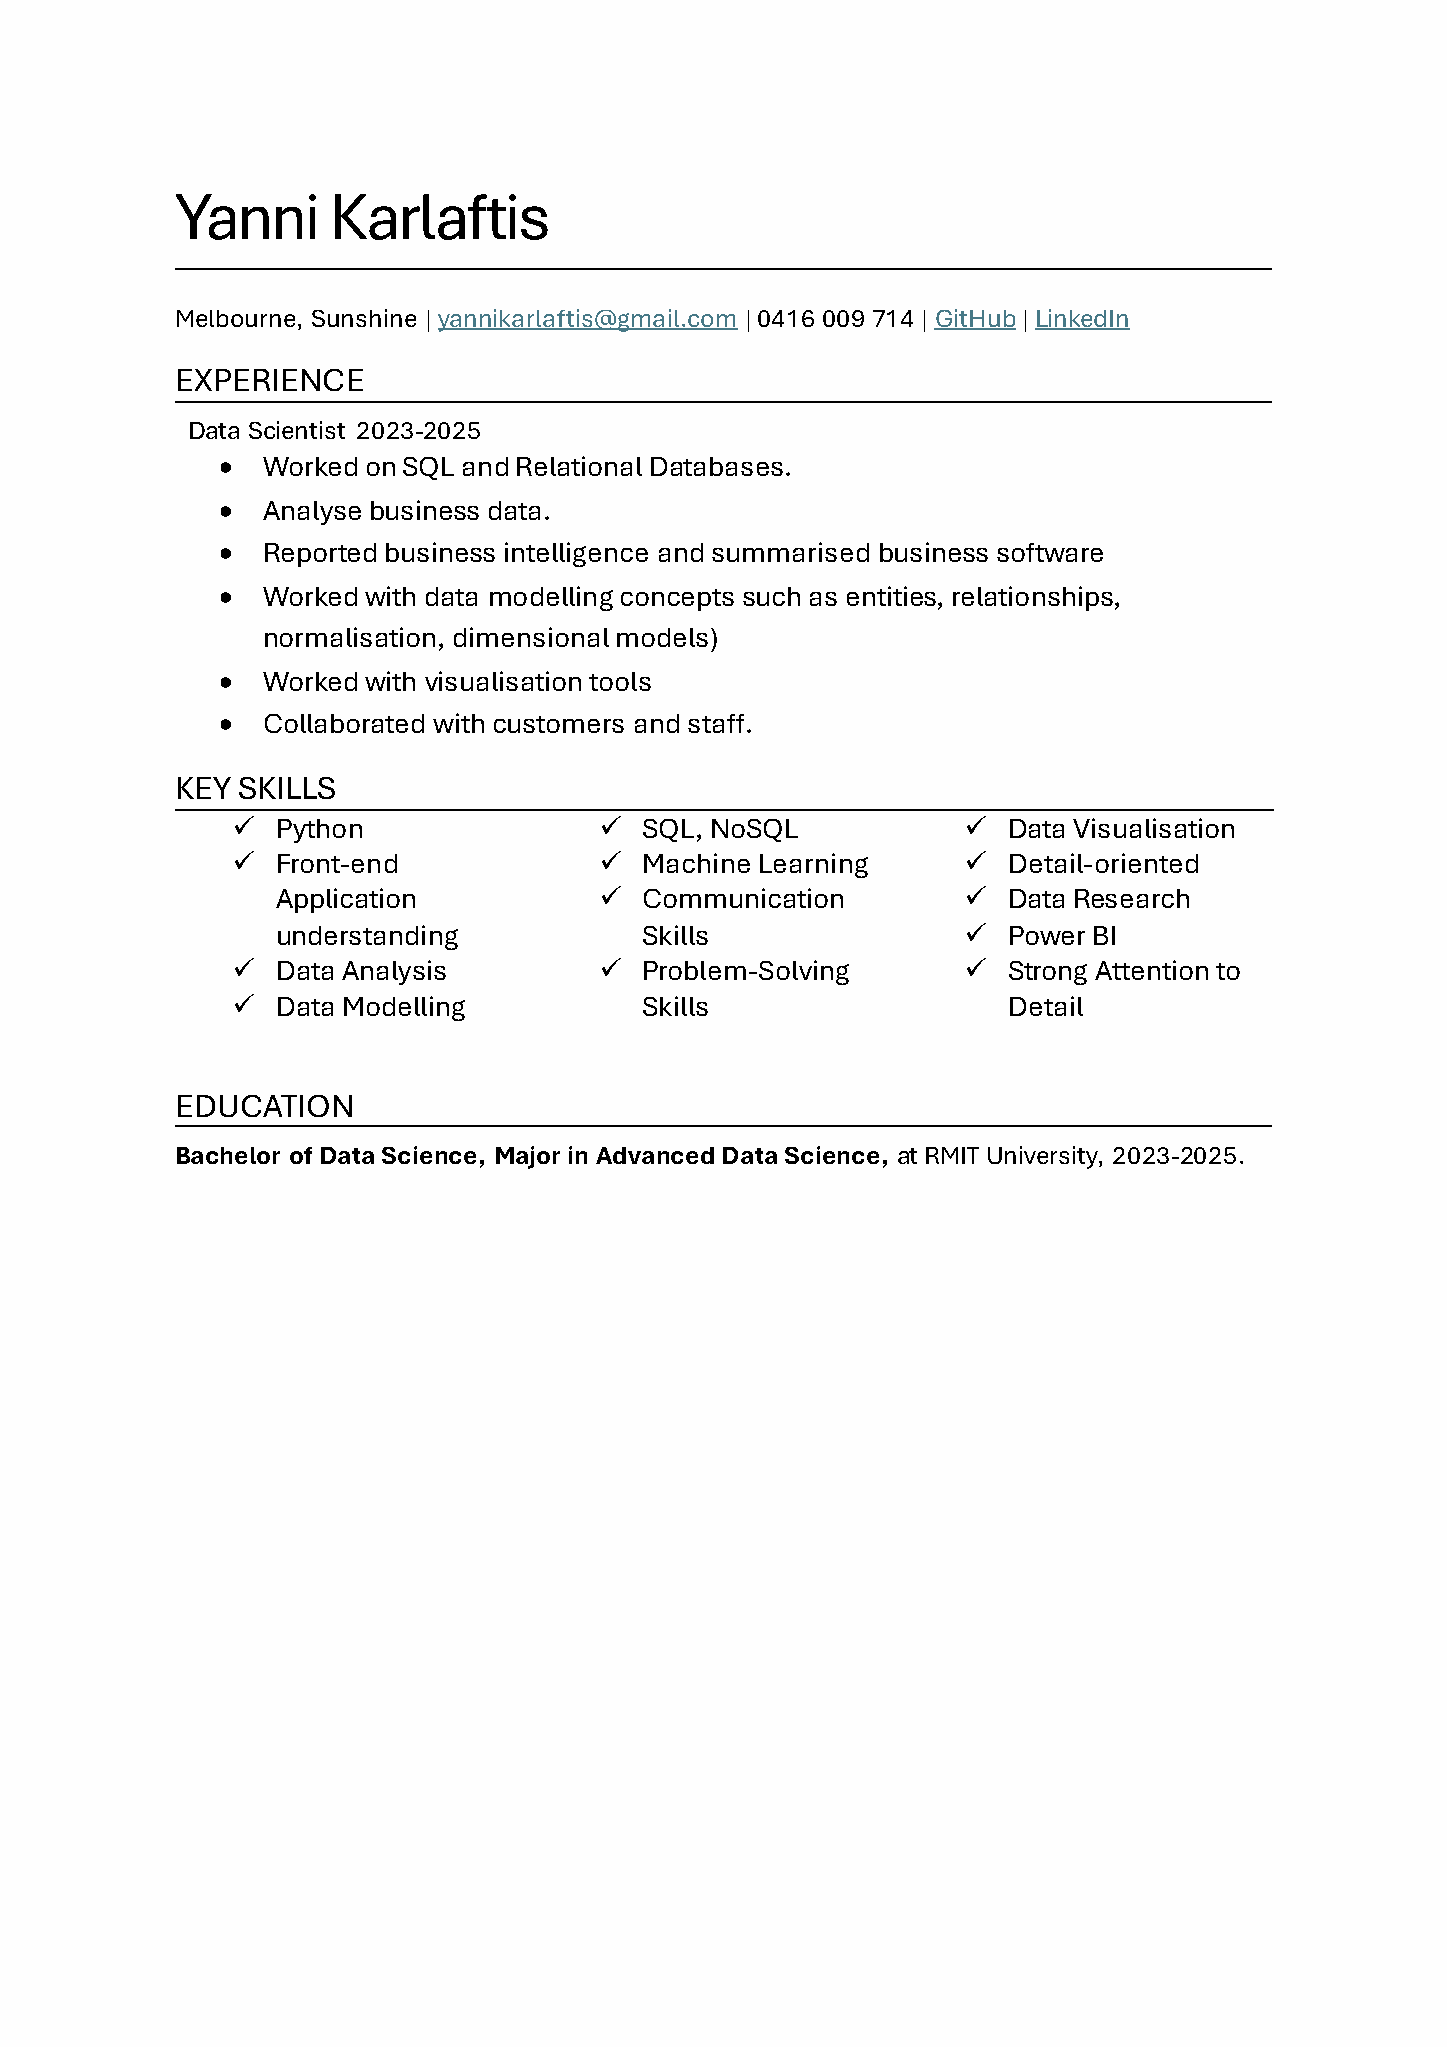

In [26]:
pages[0].to_image(resolution=175)

In [27]:
resume_df

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word,X,Y,cluster
0,0.590440,0.409160,-0.139970,-0.007290,0.565600,0.269900,0.504800,0.020234,-0.169480,-1.014500,...,72.075000,106.42945,131.516850,78.20445,43.0,28.225,Yanni,101.795925,92.31695,PERSONAL
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,135.778825,106.42945,226.324625,78.20445,43.0,28.225,Karlaftis,181.051725,92.31695,PERSONAL
2,0.306449,0.525905,-0.056477,-0.219811,0.426536,0.132020,-0.001994,-0.331740,0.107065,1.272440,...,72.075000,137.54560,124.951800,126.74560,44.0,10.800,"Melbourne,",98.513400,132.14560,PERSONAL
3,0.660050,0.481080,0.208010,-0.131810,-0.122400,-0.020926,-0.410020,0.460500,-0.257400,1.463400,...,128.451000,137.54560,171.921000,126.74560,44.0,10.800,Sunshine,150.186000,132.14560,PERSONAL
4,-0.349840,0.471390,0.333830,0.348820,-0.062755,-0.332640,0.208690,-0.266220,0.555550,0.482490,...,174.621000,137.54560,177.537000,126.74560,44.0,10.800,|,176.079000,132.14560,PERSONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.221526,0.354466,0.034770,-0.082265,-0.009074,0.397500,-0.357798,-0.043230,-0.197937,2.279000,...,322.882000,481.59560,365.693200,470.79560,47.0,10.800,"Science,",344.287600,476.19560,EDUCATION
113,-0.367690,0.598210,0.132290,0.235060,-0.046757,0.363070,0.140990,-0.100930,-0.158770,2.537100,...,368.770000,481.59560,377.658400,470.79560,44.0,10.800,at,373.214200,476.19560,EDUCATION
114,1.149900,-0.212000,-0.092440,0.050635,-0.288780,-0.272450,0.114730,-0.188760,-0.329900,-1.427400,...,380.142400,481.59560,403.297600,470.79560,44.0,10.800,RMIT,391.720000,476.19560,EDUCATION
115,0.142769,0.226675,0.053690,-0.167552,0.155595,0.105450,-0.279998,-0.244965,-0.204500,2.571300,...,405.900400,481.59560,454.168800,470.79560,44.0,10.800,"University,",430.034600,476.19560,EDUCATION


In [28]:
resume_sections = segmentate(resume_df, combined_clusters)

In [29]:
resume_sections 

{'EDUCATION': ['EDUCATION Bachelor of Data Science, Major in Advanced Data Science, at RMIT University, 2023-2025.'],
 'EXPERIENCE': ['EXPERIENCE Data Scientist 2023-2025',
  'Worked on SQL and Relational Databases.',
  'Analyse business data.',
  'Reported business intelligence and summarised business software',
  'Worked with data modelling concepts such as entities, relationships, normalisation, dimensional models)',
  'Worked with visualisation tools',
  'Collaborated with customers and staff.'],
 'SKILLS': ['KEY SKILLS',
  'Python',
  'Front-end Application understanding',
  'Data Analysis',
  'Data Modelling',
  'SQL, NoSQL',
  'Machine Learning',
  'Communication Skills',
  'Problem-Solving Skills',
  'Data Visualisation',
  'Detail-oriented',
  'Data Research',
  'Power BI',
  'Strong Attention to Detail'],
 'PERSONAL': ['Yanni Karlaftis Melbourne, Sunshine | yannikarlaftis@gmail.com | 0416 009 714 | GitHub | LinkedIn']}

#### Chunk and Classify Job Listing

In [31]:
filename = 'models/job_listing_vectorizer.joblib'

vectorizer = joblib.load(filename)

In [32]:
filename = 'models/job_listing_rf_classifier.joblib'

job_listing_tf_classifier = joblib.load(filename)

In [33]:
filename = 'models/job_listing_label_encoder.joblib'

job_listing_label_encoder = joblib.load(filename)

In [34]:
def chunk_text(text: str) -> list[str]: return re.split(r"[\n:.]", text)

In [35]:
def clean_chunks(chunks: list[str]) -> list[str]:
    cleaned_chunks = []
    for chunk in chunks:
        chunk = chunk.strip()
        if chunk:
            cleaned_chunks.append(chunk)
        
    return cleaned_chunks

In [36]:
def vectorize_chunks(chunks: list[str], vectorizer: TfidfVectorizer()) -> pd.DataFrame:
    vectorized_chunks = vectorizer.transform([chunk for chunk in chunks])
    vectorized_chunks_df = pd.DataFrame(vectorized_chunks.toarray(), columns=vectorizer.get_feature_names_out())
    return vectorized_chunks_df

In [37]:
def classify_chunks(vectorized_chunks: pd.DataFrame, rf: RandomForestClassifier()) -> list[int]: return rf.predict(vectorized_chunks)

In [38]:
chunks = chunk_text(text=job_listing)

chunks = clean_chunks(chunks=chunks)

job_listing_vectorized_chunks_df = vectorize_chunks(chunks=chunks, 
                                                    vectorizer=vectorizer)

results = classify_chunks(vectorized_chunks=job_listing_vectorized_chunks_df, 
                          rf=job_listing_tf_classifier)

In [39]:
job_listing_sections = {"EDUCATION": [], "EXPERIENCE": [], "SKILLS":[], "RESPONSIBILITIES":[], "NOISE":[]}

decoded_labels = job_listing_label_encoder.inverse_transform(results.reshape(-1,1))
zipped_classified_chunks = zip(chunks, decoded_labels)

for i in zipped_classified_chunks:
    job_listing_sections[i[1][0]].append(i[0])

In [40]:
job_listing_sections

{'EDUCATION': ['Bachelor degree in Data Science'],
 'EXPERIENCE': ['Exposure to relational databases and SQL through study, projects, internships, or early work experience',
  'Data analysis, Data engineering, Data modelling experience',
  'Exposure in business intelligence or reporting & software development',
  'At least 2 years of experience'],
 'SKILLS': ['Basic understanding of how front‑end applications interact with back‑end databases or APIs',
  'Strong analytical and problem‑solving skills, with the ability to break down ambiguous problems',
  'Clear written communication skills and a detail‑oriented approach to documentation',
  'Familiarity with data modelling concepts (entities, relationships, normalisation, dimensional models)',
  'Reporting/visualisation tools (e'],
 'RESPONSIBILITIES': ['Analyse front‑end systems and workflows to understand how fields map to backend databases',
  'Contribute to logical and conceptual data models describing entities, relationships, and ke

#### Embed

In [42]:
from transformers import BertTokenizer
from transformers.models.bert.modeling_bert import BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [43]:
# Function to get BERT embeddings
def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [44]:
# Generate embeddings for each segmentation
embedded_resume_sections = {}
for section, texts in resume_sections.items():
    embedded_resume_sections[section] = np.array([get_bert_embedding(text, tokenizer, model) 
                                           for text in texts]
    )

In [45]:
embedded_job_listing_sections = {}
for section, texts in job_listing_sections.items():
    embedded_job_listing_sections[section] = np.array([get_bert_embedding(text, tokenizer, model) 
                                           for text in texts]
    )

#### Compare Resume and Job Listing

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
def create_similarity_matrix(resume_embeddings: list, job_listing_embeddings: list):
    similarity_matrix = []
    for i in job_listing_embeddings:
        similarity_arr = []
        for j in resume_embeddings:
            similarity_arr.append(cosine_similarity([i], [j])[0][0])
        similarity_matrix.append(similarity_arr)
    return similarity_matrix

In [49]:
def best_match_aggregation(similarity_matrix: list) -> (float, float):
    best_matches = [max(arr) for arr in similarity_matrix]
    aggregated_final_score = sum(best_matches) / len(best_matches)
    return aggregated_final_score, best_matches

In [50]:
def compare_resume_and_job_listing(resume_embeddings: list, job_listing_embeddings: list, report: bool=True) -> float:
    ##---EXPERIENCE---##
    experience_matrix = create_similarity_matrix(resume_embeddings["EXPERIENCE"], job_listing_embeddings["EXPERIENCE"])
    aggregated_experience_final_score, best_experience_matches = best_match_aggregation(experience_matrix)
    if report == True:
        print("##---EXPERIENCE---##")
        print(f"Total: {aggregated_experience_final_score}")
        print(f"Overall: {best_experience_matches}")
        print("\n")

    ##---EDUCATION---##
    education_matrix = create_similarity_matrix(resume_embeddings["EDUCATION"], job_listing_embeddings["EDUCATION"])
    aggregated_education_final_score, best_education_matches = best_match_aggregation(education_matrix)
    if report == True:
        print("##---EDUCATION---##")
        print(f"Total: {aggregated_education_final_score}")
        print(f"Overall: {best_education_matches}")
        print("\n")

    ##---SKILLS---##
    skills_matrix = create_similarity_matrix(resume_embeddings["SKILLS"], job_listing_embeddings["SKILLS"])
    aggregated_skills_final_score, best_skills_matches = best_match_aggregation(skills_matrix)
    if report == True:
        print("##---SKILLS---##")
        print(f"Total: {aggregated_skills_final_score}")
        print(f"Overall: {best_skills_matches}")
        print("\n")

    overall_similarity = (aggregated_skills_final_score + aggregated_education_final_score + aggregated_experience_final_score) / 3
    if report == True:
        print("##---RESULT---##")
        print(f"Total Similarity: {overall_similarity}")
    
    return overall_similarity

In [51]:
overall_similarity = compare_resume_and_job_listing(resume_embeddings=embedded_resume_sections,
                                                   job_listing_embeddings=embedded_job_listing_sections)

##---EXPERIENCE---##
Total: 0.7162197679281235
Overall: [0.6953728, 0.81492054, 0.77325284, 0.58133286]


##---EDUCATION---##
Total: 0.7123333215713501
Overall: [0.7123333]


##---SKILLS---##
Total: 0.7425832867622375
Overall: [0.8045919, 0.7485436, 0.75660247, 0.6853281, 0.7178503]


##---RESULT---##
Total Similarity: 0.7237121254205704
